In [1]:
import pandas as pd
import wandb
from tqdm.notebook import tqdm
import pickle
import torch
from os.path import exists
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.ticker import MaxNLocator
from seaborn import heatmap
from gpytorch.kernels import ScaleKernel, RBFKernel
from gp.soft_gp.soft_gp import SoftGP

from data.get_uci import all_datasets
from analysis.util import fetch, init_uci_dict, get_uci_info

In [2]:
filters = {
    "group": "benchmark"
}
raw = fetch("soft-gp-3", filters)

100%|██████████| 150/150 [01:09<00:00,  2.17it/s]


In [3]:
uci_info = get_uci_info()

In [4]:
uci_dict = {}
for exp in raw:
    model = exp.config["model.name"]
    dataset = exp.config["dataset.name"]
    dtype = exp.config["model.dtype"]
    seed = exp.config["training.seed"]
    train_frac = float(exp.config["dataset.train_frac"])
    uci_dict[(dataset, seed, model)] = exp.history

print(uci_dict.keys())

dict_keys([('pol', 6535, 'soft-gp'), ('pol', 6535, 'svi-gp'), ('pol', 6535, 'sv-gp'), ('elevators', 6535, 'soft-gp'), ('elevators', 6535, 'svi-gp'), ('elevators', 6535, 'sv-gp'), ('bike', 6535, 'soft-gp'), ('bike', 6535, 'svi-gp'), ('bike', 6535, 'sv-gp'), ('kin40k', 6535, 'soft-gp'), ('kin40k', 6535, 'svi-gp'), ('kin40k', 6535, 'sv-gp'), ('protein', 6535, 'soft-gp'), ('protein', 6535, 'svi-gp'), ('protein', 6535, 'sv-gp'), ('keggdirected', 6535, 'soft-gp'), ('keggdirected', 6535, 'svi-gp'), ('keggdirected', 6535, 'sv-gp'), ('slice', 6535, 'soft-gp'), ('slice', 6535, 'svi-gp'), ('slice', 6535, 'sv-gp'), ('keggundirected', 6535, 'soft-gp'), ('keggundirected', 6535, 'svi-gp'), ('keggundirected', 6535, 'sv-gp'), ('3droad', 6535, 'soft-gp'), ('3droad', 6535, 'svi-gp'), ('3droad', 6535, 'sv-gp'), ('song', 6535, 'soft-gp'), ('song', 6535, 'svi-gp'), ('song', 6535, 'sv-gp'), ('buzz', 6535, 'soft-gp'), ('buzz', 6535, 'svi-gp'), ('buzz', 6535, 'sv-gp'), ('houseelectric', 6535, 'soft-gp'), ('hou

In [5]:
seeds = [6535, 8830, 92357]
num_inducings = [512]
tmp = {
    "N": [int(np.floor(N * 0.9)) for _, N, _, _ in uci_info],
    "D": [D for _, _, D, _ in uci_info],
}
models = ["soft-gp"]

for seed in seeds:
    for model in models:
        xs = []
        ts = []
        ls = []
        for dataset, _, _, _ in uci_info:
            try:
                xs += [uci_dict[(dataset, seed, model)]["test_rmse"][49]]
                ts += [np.array(uci_dict[(dataset, seed, model)]["epoch_time"][49]).mean()]
                ls += [uci_dict[(dataset, seed, model)]["lengthscale"][49]]
            except Exception as e:
                xs += [np.nan]
                ts += [np.nan]
                ls += [np.nan]
                print("Exception", e, model, dataset)

        tmp[f"{model}-{seed}"] = xs
        tmp[f"time-{model}-{seed}"] = ts
        tmp[f"time-{model}-{seed}"] = ts
df = pd.DataFrame(data=tmp)
df.index = [name.capitalize().replace("_", "-") for name, _, _, _ in uci_info]
df

,N,D,soft-gp-6535,time-soft-gp-6535,soft-gp-8830,time-soft-gp-8830,soft-gp-92357,time-soft-gp-92357
Pol,13500,26,0.189323,0.920105,0.202581,0.961052,0.195228,0.900016
Elevators,14939,18,0.391446,1.077393,0.397864,1.063536,0.378086,0.980811
Bike,15641,17,0.207511,1.079932,0.207647,1.171375,0.197947,1.044527
Kin40k,36000,8,0.242929,2.683587,0.228314,2.510453,0.240502,2.522129
Protein,41157,9,0.657446,2.710649,0.638127,2.639622,0.653156,2.580566
Keggdirected,43944,20,0.078620,2.885053,0.077221,2.932649,0.086597,2.804476
Slice,48150,385,0.019602,3.294770,0.018154,3.219749,0.027491,3.265250
Keggundirected,57247,27,0.115445,3.705515,0.111015,3.754544,0.117980,3.553524
3droad,391386,3,0.607416,24.819072,0.607177,24.781682,0.605562,24.193867
Song,270000,90,0.798511,17.977834,0.790525,17.534315,0.790360,17.380318


In [6]:
api = wandb.Api()
for exp in tqdm(raw):
    run = api.run(f'bogp/soft-gp-3/{exp.run.id}')
    if exp.config["training.seed"] == 6535:
        for artifact in run.logged_artifacts():
            print(artifact.name)
            artifact.download(root=f"visualize/{artifact.name}/")

  0%|          | 0/150 [00:00<?, ?it/s]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


inducing_points_softgp_pol_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_pol_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_pol_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-xo96qpu4-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_512_1024_0.5_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-mb1zv7a5-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_pol_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-tconcpls-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_pol_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-x25do9yg-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_elevators_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qvqn8sxy-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xm2578g1-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_elevators_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-mf48qfzh-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_elevators_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7vka34q2-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_bike_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-w5c7b5fk-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-x30vej7a-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_bike_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-c038y7ip-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_bike_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-5jck5xrl-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_kin40k_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-nys448b5-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xtw5oeja-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_kin40k_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-beadof8p-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_kin40k_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-1zqwv91q-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_protein_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-gf7v6hhn-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7rdi2dd3-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_protein_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-pji8rhqw-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_protein_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-2kpq0udo-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggdirected_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-srqthy6n-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-0rtrekaj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggdirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qdht2pzx-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggdirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-xmwvs19o-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_slice_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-u7isa8u2-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ik6mjy97-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_slice_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-13utfb8o-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_slice_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-cz97j81p-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_keggundirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_keggundirected_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-sa5ifinj-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-ejvi42f0-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_keggundirected_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-qt11p9g9-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svgp_keggundirected_512_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-1g38b2jq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_0:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_10:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_20:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_30:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_3droad_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_3droad_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-adovh86r-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-j0kwjn9v-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_3droad_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-i9w0pj4z-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_song_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-uqrvlmee-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-5nz3qa03-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_song_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-wefynrwd-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_buzz_512_1024_0.001_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-f95eewuq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-4gzdtx7x-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_buzz_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-7nywrszm-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_40:v1


wandb:   1 of 1 files downloaded.  


inducing_points_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


K_zz_softgp_houseelectric_512_1024_0.001_6535_49:v1


wandb:   1 of 1 files downloaded.  


run-l5dcs7lr-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_512_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-u740rifq-history:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_0:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_10:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_20:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_30:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_40:v0


wandb:   1 of 1 files downloaded.  


inducing_points_svigp_houseelectric_1024_1024_0.5_6535_49:v0


wandb:   1 of 1 files downloaded.  


run-0s567ogr-history:v0


wandb:   1 of 1 files downloaded.  


run-gzbm1w34-history:v0


wandb:   1 of 1 files downloaded.  


run-pkrdrncc-history:v0


wandb:   1 of 1 files downloaded.  


In [7]:
def load(dataset):
    kernels = []
    softgps = []
    K_zzs = []
    epochs = [0, 10, 20, 30, 40, 50]
    # epochs = [0, 20, 40, 60, 80, 99]
    for epoch, epoch_exact in zip([0, 10, 20, 30, 40, 49], epochs):
        K_zz = np.load(f"artifacts/K_zz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/K_zz.npy")
        # W_xz = np.load(f"artifacts/W_xz_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/W_xz.npy")
        z = torch.tensor(np.load(f"artifacts/inducing_points_softgp_{dataset}_512_1024_0.001_6535_{epoch}:v0/array.npy"), dtype=torch.float32)
        print(z.shape)
        l = uci_dict[(dataset, 6535, "soft-gp")]["lengthscale"][epoch]
        s = uci_dict[(dataset, 6535, "soft-gp")]["outputscale"][epoch]
        print("l", l, "s", s)
        skernel = RBFKernel()
        skernel.lengthscale = l
        softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)
        softgp.kernel.base_kernel.outputscale = s

        kernel = ScaleKernel(RBFKernel())
        l = uci_dict[(dataset, 6535, "exact")]["lengthscale"][epoch_exact]
        s = uci_dict[(dataset, 6535, "exact")]["outputscale"][epoch_exact]
        kernel.base_kernel.lengthscale = l
        kernel.outputscale = s
        print("l", l, "s", s)
        print(K_zz.shape, z.shape)
        kernels += [kernel]
        softgps += [softgp]
        K_zzs += [K_zz]

    return kernels, softgps, K_zzs

kernels, softgps, K_zzs = load("elevators")

torch.Size([512, 18])
l 0.6262765526771545 s 0.7715458869934082


/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_51669/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


l 0.7443966865539551 s 0.6443967223167419
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.3134465217590332 s 1.3573390245437622
l 1.3956273794174194 s 0.3008975684642792
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.476333737373352 s 1.8292913436889648
l 2.171576976776123 s 0.1761978417634964
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5237510204315186 s 2.3083763122558594
l 2.5978963375091553 s 0.1609201580286026
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.537253737449646 s 2.7909035682678223
l 2.830556869506836 s 0.1962786465883255
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5381413698196411 s 3.2192158699035645
l 3.1024153232574463 s 0.24466736614704132
(512, 512) torch.Size([512, 18])


/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_51669/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


In [8]:
from data.get_uci import (
        PoleteleDataset,
        ElevatorsDataset,
        BikeDataset,
        Kin40KDataset,
        ProteinDataset,
        KeggDirectedDataset,
        CTSlicesDataset,
        KeggUndirectedDataset,
        RoadDataset,
        SongDataset,
        BuzzDataset,
        HouseElectricDataset,
    )
from gp.util import flatten_dataset, split_dataset
np.random.seed(6535)
torch.manual_seed(6535)

In [24]:
kernels, softgps, K_zzs = load("elevators")

my_dataset = ElevatorsDataset(f"../data/uci_datasets/uci_datasets/elevators/data.csv")
# Generate splits
train_dataset, val_dataset, test_dataset = split_dataset(
    my_dataset,
    train_frac=0.9,
    val_frac=0.0
)
test_features, test_labels = flatten_dataset(test_dataset)
xs = test_features[0:64,:]

norms = []
with torch.no_grad():
    for idx, (kernel, softgp, K_zz) in enumerate(zip(kernels, softgps, K_zzs)):
        W_xz = softgp._interp(xs)
        Q_xx = W_xz @ K_zz @ W_xz.T
        K_xx = kernel(xs, xs).evaluate()
        norms += [torch.linalg.matrix_norm(K_xx - Q_xx, ord='fro') / torch.linalg.matrix_norm(K_xx, ord='fro')]

torch.Size([512, 18])
l 0.6262765526771545 s 0.7715458869934082
l 0.7443966865539551 s 0.6443967223167419
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.3134465217590332 s 1.3573390245437622
l 1.3956273794174194 s 0.3008975684642792
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.476333737373352 s 1.8292913436889648
l 2.171576976776123 s 0.1761978417634964
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5237510204315186 s 2.3083763122558594
l 2.5978963375091553 s 0.1609201580286026
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.537253737449646 s 2.7909035682678223
l 2.830556869506836 s 0.1962786465883255
(512, 512) torch.Size([512, 18])
torch.Size([512, 18])
l 1.5381413698196411 s 3.2192158699035645
l 3.1024153232574463 s 0.24466736614704132
(512, 512) torch.Size([512, 18])
SIZE (16599, 19)


/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_51669/824547403.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  softgp = SoftGP(skernel, inducing_points=torch.tensor(z), use_scale=True)


  0%|          | 0/1 [00:00<?, ?it/s]

/var/folders/6k/g8w9pg6j4b3b_76hhg422g440000gn/T/ipykernel_51669/1610380466.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


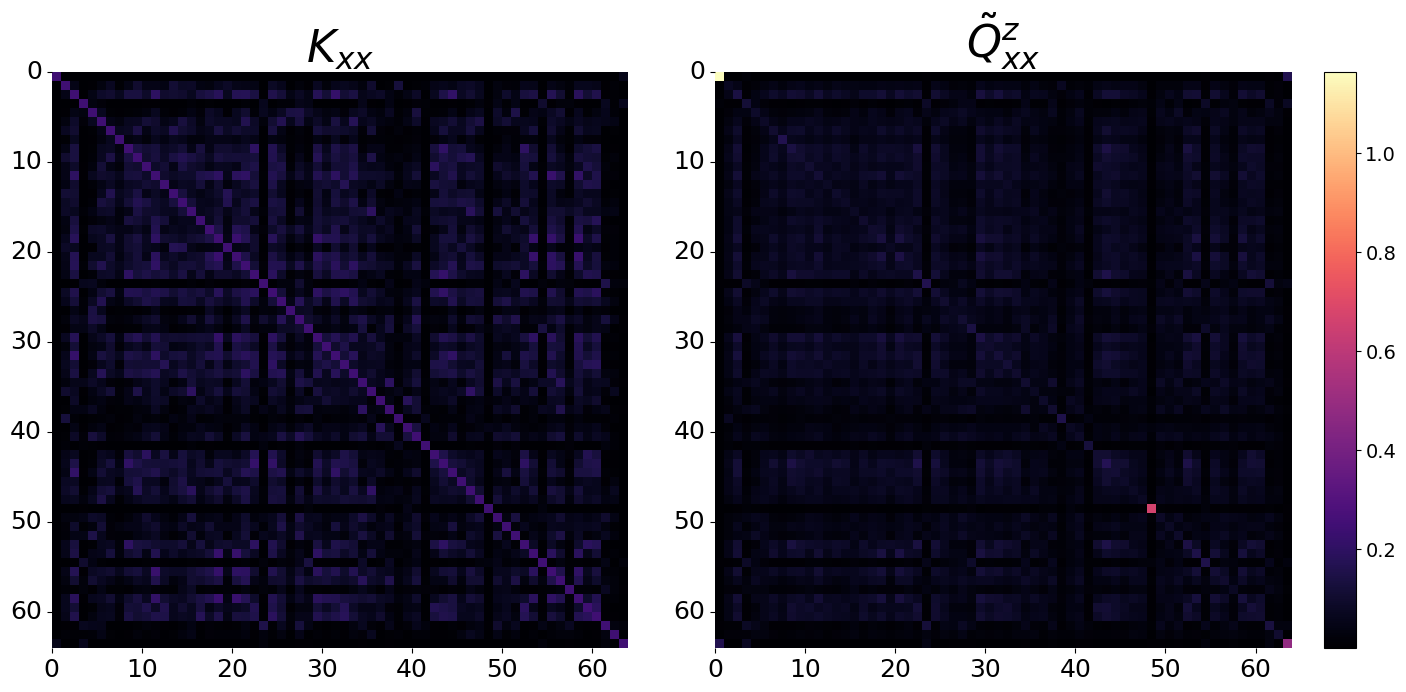

In [28]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_two_kernel_heatmaps_with_shared_colorbar(kernel1, kernel2, log_scale=False, cmap='viridis',
                                                  colorbar_shrink=0.76, title1=r"$K_{xx}$", title2=r"$\tilde{Q}_{xx}^z$", clip_low=1, clip_high=99.9):
    # Clip the outliers using percentiles to focus on the bulk of the data
    vmin = min(np.percentile(kernel1, clip_low), np.percentile(kernel2, clip_low))
    vmax = max(np.percentile(kernel1, clip_high), np.percentile(kernel2, clip_high))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.15})
    
    # First heatmap
    ax1.set_title(title1, fontsize=32)
    if log_scale:
        heatmap1 = sns.heatmap(kernel1, ax=ax1, cmap=cmap, cbar=False, norm=LogNorm(vmin=vmin, vmax=vmax))
    else:
        heatmap1 = sns.heatmap(kernel1, ax=ax1, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)

    ax1.set_xticks(np.arange(0, kernel1.shape[1], 10))
    ax1.set_yticks(np.arange(0, kernel1.shape[0], 10))
    ax1.set_xticklabels(np.arange(0, kernel1.shape[1], 10), fontsize=18)
    ax1.set_yticklabels(np.arange(0, kernel1.shape[0], 10), fontsize=18)
    ax1.tick_params(axis='y', rotation=0)  # Ensure y-tick labels are not rotated
    ax1.set_aspect('equal')

    # Second heatmap
    ax2.set_title(title2, fontsize=32)
    if log_scale:
        heatmap2 = sns.heatmap(kernel2, ax=ax2, cmap=cmap, cbar=False, norm=LogNorm(vmin=vmin, vmax=vmax))
    else:
        heatmap2 = sns.heatmap(kernel2, ax=ax2, cmap=cmap, cbar=False, vmin=vmin, vmax=vmax)

    ax2.set_xticks(np.arange(0, kernel2.shape[1], 10))
    ax2.set_yticks(np.arange(0, kernel2.shape[0], 10))
    ax2.set_xticklabels(np.arange(0, kernel2.shape[1], 10), fontsize=18)
    ax2.set_yticklabels(np.arange(0, kernel2.shape[0], 10), fontsize=18)
    ax2.tick_params(axis='y', rotation=0)  # Ensure y-tick labels are not rotated
    ax2.set_aspect('equal')

    # Create single colorbar aligned to a single heatmap size
    cbar_ax = fig.add_axes([0.92, ax1.get_position().y0, 0.02, ax1.get_position().height])  # Align height with first heatmap
    if log_scale:
        norm = LogNorm(vmin=vmin, vmax=vmax)
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    colorbar = fig.colorbar(sm, cax=cbar_ax, shrink=colorbar_shrink)
    colorbar.ax.tick_params(labelsize=14)  # Set color bar font size

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
    plt.show()

# Example usage with K_xx and Q_xx
plot_two_kernel_heatmaps_with_shared_colorbar(K_xx, Q_xx, log_scale=False, cmap="magma", clip_low=0, clip_high=100)